In [1]:
import json, os, pickle, random
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn

import qiskit
from qiskit import QuantumCircuit, execute
from qiskit.compiler import transpile
from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.quantum_info import SparsePauliOp, Operator
from qiskit.circuit.library import CXGate, RXGate, IGate, ZGate
from qiskit.providers.fake_provider import FakeMontreal, FakeLima

from blackwater.data.utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
    create_meas_data_from_estimators
)

from mlp import MLP1, MLP2, MLP3, encode_data

from mbd_utils import cal_z_exp, generate_disorder, construct_mbl_circuit, calc_imbalance, modify_and_add_noise_to_model

import matplotlib.pyplot as plt
import seaborn as sns
from noise_utils import AddNoise
from typing import Optional, Union
from qiskit.opflow import PauliSumOp
from qiskit.quantum_info import random_pauli_list, SparsePauliOp

D = {'output': 'mpl', 'fold': -1}

In [2]:
def fix_random_seed(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    print(f'random seed fixed to {seed}')

In [3]:
backend = FakeLima()
properties = get_backend_properties_v1(backend)

## Local
backend_ideal = QasmSimulator() # Noiseless
backend_noisy = AerSimulator.from_backend(FakeLima()) # Noisy

run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}
run_config_noisy = {'shots': 10000, 'backend': backend_noisy, 'name': 'noisy'}

In [4]:
def load_circuits(data_dir, f_ext='.json'):
    circuits = []
    ideal_exp_vals = []
    noisy_exp_vals = []
    meas_basis = []
    data_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(f_ext)]
    for data_file in tqdm(data_files, leave=True):
        if f_ext == '.json':
            for entry in json.load(open(data_file, 'r')):
                circuits.append(QuantumCircuit.from_qasm_str(entry['circuit']))
                ideal_exp_vals.append(entry['ideal_exp_value'])
                noisy_exp_vals.append(entry['noisy_exp_values'])
        elif f_ext == '.pk':
            for entry in pickle.load(open(data_file, 'rb')):
                circuits.append(entry['circuit'])
                ideal_exp_vals.append(entry['ideal_exp_value'])
                noisy_exp_vals.append(entry['noisy_exp_values'])
                meas_basis.append(entry['meas_basis'])
    return circuits, ideal_exp_vals, noisy_exp_vals, meas_basis

In [5]:
# train_circuits, train_ideal_exp_vals, train_noisy_exp_vals, train_meas_bases = load_circuits('./data/ising_init_from_qasm_tomo/train/', '.pk')
# print(len(train_circuits))
#
# test_circuits, test_ideal_exp_vals, test_noisy_exp_vals, test_meas_bases = load_circuits('./data/ising_init_from_qasm_tomo/val/', '.pk')
# print(len(test_circuits))

circuits, ideal_exp_vals, noisy_exp_vals, meas_bases = load_circuits('./data/ising_init_from_qasm_tomo/', '.pk')
print(len(circuits))

  0%|          | 0/1 [00:00<?, ?it/s]

4096


In [150]:
distances = []
for sep in [1] + list(2**np.arange(4, 12)):
    train_circuits, train_ideal_exp_vals, train_noisy_exp_vals, train_meas_bases = circuits[:sep], ideal_exp_vals[:sep], noisy_exp_vals[:sep], meas_bases[:sep]
    test_circuits, test_ideal_exp_vals, test_noisy_exp_vals, test_meas_bases = circuits[sep:], ideal_exp_vals[sep:], noisy_exp_vals[sep:], meas_bases[sep:]

    print(len(train_circuits), len(test_circuits))

    train_observables = [encode_pauli_sum_op(SparsePauliOp(basis))[0] for basis in train_meas_bases]
    test_observables = [encode_pauli_sum_op(SparsePauliOp(basis))[0] for basis in test_meas_bases]
    train_noisy_exp_vals_copy = [x[0][0] for x in train_noisy_exp_vals]
    test_noisy_exp_vals_copy = [x[0][0] for x in test_noisy_exp_vals]
    X_train, y_train = encode_data(train_circuits, properties, train_ideal_exp_vals, train_noisy_exp_vals_copy, num_qubits=1, meas_bases=train_observables)
    X_test, y_test = encode_data(test_circuits, properties, test_ideal_exp_vals, test_noisy_exp_vals_copy, num_qubits=1, meas_bases=test_observables)

    BATCH_SIZE = 32
    fix_random_seed(0)
    test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*1000, shuffle=False)

    X_train = pd.DataFrame(X_train)
    y_train = pd.DataFrame(y_train)
    X_test = pd.DataFrame(X_test)
    y_test = pd.DataFrame(y_test)

    from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
    rfr_tree_list = []
    rfr = RandomForestRegressor(n_estimators=100)
    rfr.fit(X_train, y_train)
    rfr_tree_list.append(rfr)

    fix_random_seed(0)
    num_spins = 1

    for batch_X, batch_y in test_loader:
        out = []
        for q, model in enumerate(rfr_tree_list):
            out.append(model.predict(batch_X[:, :]))
        out = np.array(out).transpose()

        for ideal, noisy, ngm_mitigated in zip(
            batch_y.tolist(),
            batch_X[:, 54].tolist(),
            out.tolist()
        ):
            for q in range(num_spins):
                ideal_q = ideal[q]
                noisy_q = noisy
                ngm_mitigated_q = ngm_mitigated[q]
                distances.append({
                    "num_train_samples": sep,
                    f"ideal_{q}": ideal_q,
                    f"noisy_{q}": noisy_q,
                    f"ngm_mitigated_{q}": ngm_mitigated_q,
                    f"dist_noisy_{q}": np.abs(ideal_q - noisy_q),
                    f"dist_mitigated_{q}": np.abs(ideal_q - ngm_mitigated_q),
                    f"dist_l2_noisy_{q}": np.sqrt(np.square(ideal_q - noisy_q)),
                    f"dist_l2_mitigated_{q}": np.sqrt(np.square(ideal_q - ngm_mitigated_q)),
                })

df = pd.DataFrame(distances)

1 4095
random seed fixed to 0
random seed fixed to 0
16 4080


/var/folders/kj/mfqyg_tj77nf4gt67lvscdkw0000gn/T/ipykernel_23080/1760454320.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(X_train, y_train)


random seed fixed to 0
random seed fixed to 0
32 4064


/var/folders/kj/mfqyg_tj77nf4gt67lvscdkw0000gn/T/ipykernel_23080/1760454320.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(X_train, y_train)


random seed fixed to 0
random seed fixed to 0
64 4032


/var/folders/kj/mfqyg_tj77nf4gt67lvscdkw0000gn/T/ipykernel_23080/1760454320.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(X_train, y_train)


random seed fixed to 0
random seed fixed to 0
128 3968


/var/folders/kj/mfqyg_tj77nf4gt67lvscdkw0000gn/T/ipykernel_23080/1760454320.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(X_train, y_train)


random seed fixed to 0
random seed fixed to 0
256 3840


/var/folders/kj/mfqyg_tj77nf4gt67lvscdkw0000gn/T/ipykernel_23080/1760454320.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(X_train, y_train)


random seed fixed to 0
random seed fixed to 0
512 3584


/var/folders/kj/mfqyg_tj77nf4gt67lvscdkw0000gn/T/ipykernel_23080/1760454320.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(X_train, y_train)


random seed fixed to 0
random seed fixed to 0


/var/folders/kj/mfqyg_tj77nf4gt67lvscdkw0000gn/T/ipykernel_23080/1760454320.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(X_train, y_train)


1024 3072
random seed fixed to 0


/var/folders/kj/mfqyg_tj77nf4gt67lvscdkw0000gn/T/ipykernel_23080/1760454320.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(X_train, y_train)


random seed fixed to 0
2048 2048
random seed fixed to 0


/var/folders/kj/mfqyg_tj77nf4gt67lvscdkw0000gn/T/ipykernel_23080/1760454320.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(X_train, y_train)


random seed fixed to 0


In [151]:
df2 = df.groupby('num_train_samples').agg({'dist_l2_mitigated_0': ['mean', 'std'],
                                           'dist_l2_noisy_0': ['mean', 'std']})
df2

dist_l2_mitigated_0           dist_l2_noisy_0          
                                 mean       std            mean       std
num_train_samples                                                        
1                            0.410319  0.172300        0.213739  0.070899
16                           0.082366  0.065694        0.213745  0.070928
32                           0.028861  0.030291        0.213650  0.070976
64                           0.023813  0.033835        0.213588  0.071042
128                          0.018508  0.030250        0.213462  0.071249
256                          0.016796  0.027561        0.213493  0.070991
512                          0.014168  0.025887        0.212991  0.071668
1024                         0.010799  0.021680        0.212269  0.071902
2048                         0.008121  0.019255        0.212320  0.071764

In [155]:
ticks

array([-500.,    0.,  500., 1000., 1500., 2000., 2500.])

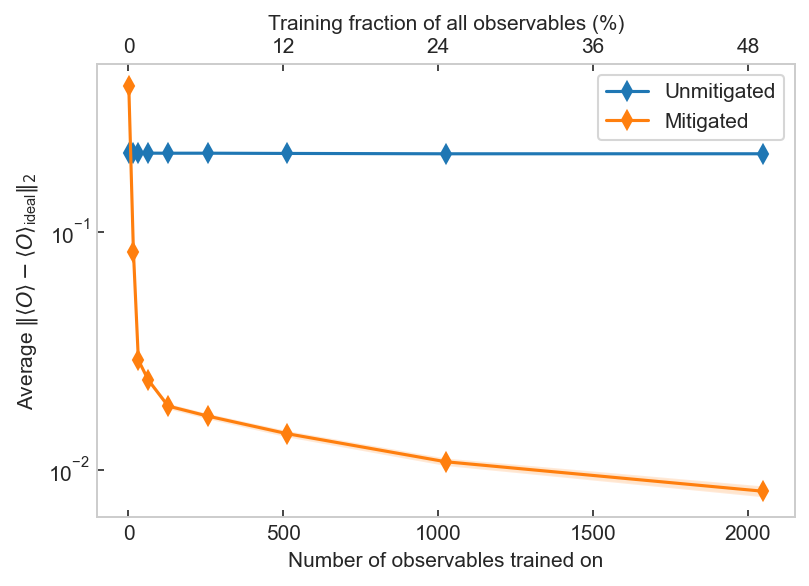

In [156]:
fig = plt.figure(dpi=150)
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

x = df2.index

y = df2['dist_l2_noisy_0']['mean']
ax1.plot(x, y, label='Unmitigated', marker='d')
ax1.fill_between(x,
                 y-df2['dist_l2_noisy_0']['std']/np.sqrt(4**6 - x),
                 y+df2['dist_l2_noisy_0']['std']/np.sqrt(4**6 - x),
                 alpha=0.2)

y = df2['dist_l2_mitigated_0']['mean']
ax1.plot(x, y, label='Mitigated', marker='d')
ax1.fill_between(x,
                 y-df2['dist_l2_mitigated_0']['std']/np.sqrt(4**6 - x), y+df2['dist_l2_mitigated_0']['std']/np.sqrt(4**6 - x),
                 alpha=0.2)

ax1.set_yscale('log')
# plt.xscale('log')


ax2.set_xlim(ax1.get_xlim())
ax2.set_navigate(False)
import matplotlib.ticker as mticks
ticks = ax1.get_xticks()
ax2.xaxis.set_major_locator(mticks.FixedLocator(ticks))
percent = [int(x) for x in np.array(ticks)/4**6 * 100]
ax2.set_xticklabels([str(x) for x in percent])
ax2.set_xlabel(r"Training fraction of all observables (%)")

ax1.set_ylabel(r'Average $\|\langle O\rangle-\langle O\rangle _{\mathregular{ideal}} \|_2$')
ax1.set_xlabel('Number of observables trained on')
ax1.legend()

ax1.grid(False)
ax2.grid(False)
for tick in ax1.yaxis.get_major_ticks():
    tick.tick1line.set_visible(True)
ax1.tick_params(axis='y',direction='in')
ax1.tick_params(axis='x',direction='in')
ax2.tick_params(axis='x',direction='in')
plt.show()

In [21]:
# estimator = rfr_tree_list[0]
#
# n_nodes_ = [t.tree_.node_count for t in estimator.estimators_]
# children_left_ = [t.tree_.children_left for t in estimator.estimators_]
# children_right_ = [t.tree_.children_right for t in estimator.estimators_]
# feature_ = [t.tree_.feature for t in estimator.estimators_]
# threshold_ = [t.tree_.threshold for t in estimator.estimators_]
#
# def explore_tree(estimator, n_nodes, children_left, children_right, feature, threshold,
#                 suffix='', print_tree= False, sample_id=0, feature_names=None):
#
#     if not feature_names:
#         feature_names = feature
#
#
#     assert len(feature_names) == X_test.shape[1], "The feature names do not match the number of features."
#     # The tree structure can be traversed to compute various properties such
#     # as the depth of each node and whether or not it is a leaf.
#     node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
#     is_leaves = np.zeros(shape=n_nodes, dtype=bool)
#
#     stack = [(0, -1)]  # seed is the root node id and its parent depth
#     while len(stack) > 0:
#         node_id, parent_depth = stack.pop()
#         node_depth[node_id] = parent_depth + 1
#
#         # If we have a test node
#         if (children_left[node_id] != children_right[node_id]):
#             stack.append((children_left[node_id], parent_depth + 1))
#             stack.append((children_right[node_id], parent_depth + 1))
#         else:
#             is_leaves[node_id] = True
#
#     print("The binary tree structure has %s nodes"
#           % n_nodes)
#     if print_tree:
#         print("Tree structure: \n")
#         for i in range(n_nodes):
#             if is_leaves[i]:
#                 print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
#             else:
#                 print("%snode=%s test node: go to node %s if X[:, %s] <= %s else to "
#                       "node %s."
#                       % (node_depth[i] * "\t",
#                          i,
#                          children_left[i],
#                          feature[i],
#                          threshold[i],
#                          children_right[i],
#                          ))
#             print("\n")
#         print()
#
#     # First let's retrieve the decision path of each sample. The decision_path
#     # method allows to retrieve the node indicator functions. A non zero element of
#     # indicator matrix at the position (i, j) indicates that the sample i goes
#     # through the node j.
#
#     node_indicator = estimator.decision_path(X_test)
#
#     # Similarly, we can also have the leaves ids reached by each sample.
#
#     leave_id = estimator.apply(X_test)
#
#     # Now, it's possible to get the tests that were used to predict a sample or
#     # a group of samples. First, let's make it for the sample.
#
#     sample_id = 0
#     node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
#                                         node_indicator.indptr[sample_id + 1]]
#
#     # print(X_test.iloc[sample_id,:])
#
#     print('Rules used to predict sample %s: ' % sample_id)
#     for node_id in node_index:
#         # tabulation = " "*node_depth[node_id] #-> makes tabulation of each level of the tree
#         tabulation = ""
#         if leave_id[sample_id] == node_id:
#             print("%s==> Predicted leaf index \n"%(tabulation))
#             #continue
#
#         if (X_test.iloc[sample_id, feature[node_id]] <= threshold[node_id]):
#             threshold_sign = "<="
#         else:
#             threshold_sign = ">"
#
#         print("%sdecision id node %s : (X_test[%s, '%s'] (= %s) %s %s)"
#               % (tabulation,
#                  node_id,
#                  sample_id,
#                  feature_names[feature[node_id]],
#                  X_test.iloc[sample_id, feature[node_id]],
#                  threshold_sign,
#                  threshold[node_id]))
#     print("%sPrediction for sample %d: %s"%(tabulation,
#                                           sample_id,
#                                           estimator.predict(X_test)[sample_id]))
#
#     # For a group of samples, we have the following common node.
#     sample_ids = [sample_id, 1]
#     common_nodes = (node_indicator.toarray()[sample_ids].sum(axis=0) ==
#                     len(sample_ids))
#
#     common_node_id = np.arange(n_nodes)[common_nodes]
#
#     print("\nThe following samples %s share the node %s in the tree"
#           % (sample_ids, common_node_id))
#     print("It is %s %% of all nodes." % (100 * len(common_node_id) / n_nodes,))
#
#     for sample_id_ in sample_ids:
#         print("Prediction for sample %d: %s"%(sample_id_,
#                                           estimator.predict(X_test)[sample_id_]))
#
#
# ########################### Print out the decision path (sample_id = 0) #####################################
# for i,e in enumerate(estimator.estimators_):
#     print("Tree %d\n"%i)
#     explore_tree(estimator.estimators_[i],n_nodes_[i],children_left_[i],
#                  children_right_[i], feature_[i],threshold_[i],
#                 suffix=i, sample_id=1, feature_names=["Feature_%d"%i for i in range(X_train.shape[1])])
#     print('\n'*2)

random seed fixed to 0
RMSE_noisy_0: 0.2247217175651218
RMSE_mitigated_0: 0.029507705593922372
RMSE_noisy: 0.2247217175651218
RMSE_mitigated: 0.029507705593922372


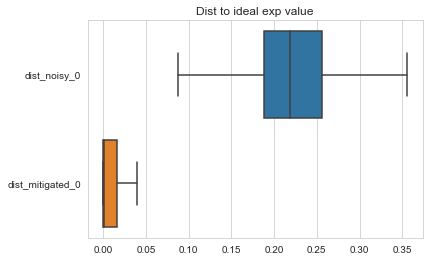

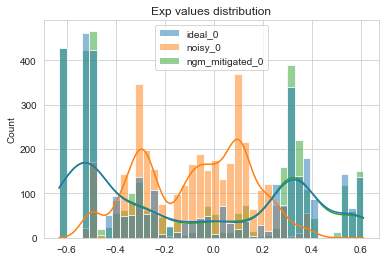

In [22]:
fix_random_seed(0)

distances = []

num_spins = 1

for batch_X, batch_y in test_loader:
    out = []
    for q, model in enumerate(rfr_tree_list):
        out.append(model.predict(batch_X[:, :]))
    out = np.array(out).transpose()

    for ideal, noisy, ngm_mitigated in zip(
        batch_y.tolist(),
        batch_X[:, 54].tolist(),
        out.tolist()
    ):
        for q in range(num_spins):
            ideal_q = ideal[q]
            noisy_q = noisy
            ngm_mitigated_q = ngm_mitigated[q]
            distances.append({
                "num_train_samples": sep,
                f"ideal_{q}": ideal_q,
                f"noisy_{q}": noisy_q,
                f"ngm_mitigated_{q}": ngm_mitigated_q,
                f"dist_noisy_{q}": np.abs(ideal_q - noisy_q),
                f"dist_mitigated_{q}": np.abs(ideal_q - ngm_mitigated_q),
                f"dist_sq_noisy_{q}": np.square(ideal_q - noisy_q),
                f"dist_sq_mitigated_{q}": np.square(ideal_q - ngm_mitigated_q),
            })

plt.style.use({'figure.facecolor':'white'})

df = pd.DataFrame(distances)

for q in range(num_spins):
    print(f'RMSE_noisy_{q}:', np.sqrt(df[f"dist_sq_noisy_{q}"].mean()))
    print(f'RMSE_mitigated_{q}:', np.sqrt(df[f"dist_sq_mitigated_{q}"].mean()))

print(f'RMSE_noisy:', np.sqrt(np.mean([df[f"dist_sq_noisy_{q}"].mean() for q in range(num_spins)])))
print(f'RMSE_mitigated:', np.sqrt(np.mean([df[f"dist_sq_mitigated_{q}"].mean() for q in range(num_spins)])))

sns.boxplot(data=df[["dist_noisy_0", "dist_mitigated_0"]], orient="h", showfliers = False)
plt.title("Dist to ideal exp value")
plt.show()

sns.histplot([df['ideal_0'], df['noisy_0'], df["ngm_mitigated_0"]], kde=True, bins=40)
plt.title("Exp values distribution")
plt.show()